<a href="https://colab.research.google.com/github/AdrianPauer/soc_ana_project/blob/main/Twitch_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
! git clone https://github.com/AdrianPauer/soc_ana_project.git

Cloning into 'soc_ana_project'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 27.11 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
#read edges
edges = pd.read_csv('soc_ana_project/large_twitch_edges.csv')

In [ ]:
#read features
attributes = pd.read_csv('soc_ana_project/large_twitch_features.csv')
print('features in dataset : ')
print(*attributes.columns)

features in dataset : 
views mature life_time created_at updated_at numeric_id dead_account language affiliate


In [ ]:
# graph construction
graph = nx.from_pandas_edgelist(edges, source = 'numeric_id_1', target = 'numeric_id_2')

Overall network characteristics

In [ ]:
degrees = dict(nx.degree(graph))
print(f'average degree : {np.mean(list(degrees.values()))}')

average degree : 80.86842261798542


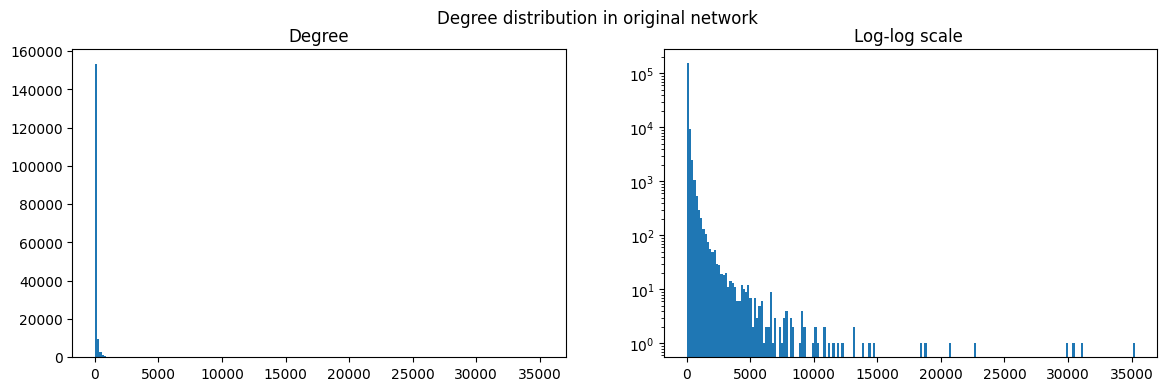

In [ ]:
# degree distribution

fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].hist(dict(degrees).values(), bins = 200)
axes[0].set_title(f'Degree')

axes[1].hist(dict(degrees).values(), log = True, bins = 200)
#axes[1].set_xscale('log')
axes[1].set_title(f'Log-log scale ')

plt.suptitle('Degree distribution in original network')
plt.show()

In [ ]:
attributes['degree'] = attributes.index.map(degrees)

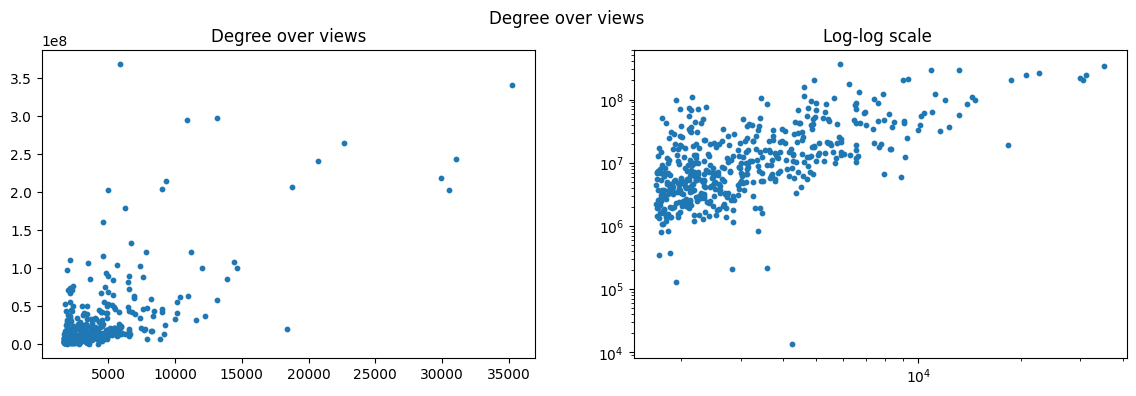

In [ ]:
# is asscociated degree (# of connections ) with number of views ?
sorted_by_degree = attributes.sort_values('degree', ascending = False)[['views','life_time','degree']][:500]

fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].scatter(sorted_by_degree['degree'], sorted_by_degree['views'], s=10)
axes[0].set_title(f'Degree over views')

axes[1].scatter(sorted_by_degree['degree'], sorted_by_degree['views'],s=10)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title(f'Log-log scale ')

plt.suptitle('Degree over views')
plt.show()

In [ ]:
# characteristics computed easily on whole graph

graph_density = nx.density(graph)
graph_assortativity = nx.degree_assortativity_coefficient(graph)
graph_avg_degree = np.mean(list(degrees.values()))
graph_components = nx.number_connected_components(graph)

In [ ]:
# subgraph of 'target_n' nodes

deg = pd.Series(degrees, name='degree')
bins = np.logspace(
    np.log10(deg.min()),
    np.log10(deg.max()),
    15
)

deg_bins = pd.cut(deg, bins=bins, include_lowest=True)
target_n = 15000
sampled_nodes = []

for b in deg_bins.unique():
    nodes_in_bin = deg_bins[deg_bins == b].index
    if len(nodes_in_bin) == 0:
        continue
    frac = len(nodes_in_bin) / len(deg)
    k = max(1, int(frac * target_n))
    sampled_nodes.extend(
        np.random.choice(nodes_in_bin, size=min(k, len(nodes_in_bin)), replace=False)
    )

sampled_nodes = list(set(sampled_nodes))
G_sub = graph.subgraph(sampled_nodes).copy()

In [ ]:
# giant component
largest_cc = max(nx.connected_components(G_sub), key=len)
G_lcc = graph.subgraph(largest_cc).copy()

In [ ]:
# caharacteristics computed on subgraph

graph_diameter = nx.diameter(G_lcc)
graph_clustering = nx.average_clustering(G_lcc)
graph_transitivity = nx.transitivity(G_lcc)
graph_average_shortest_path = nx.average_shortest_path_length(G_lcc)


In [ ]:
stats = {
    'Nodes': len(attributes),
    'Edges': len(edges),
    'Density': graph_density,
    'Avg_degree': graph_avg_degree,
    'Diameter': graph_diameter,
    'Avg_shortest_path': graph_average_shortest_path,
    'Avg_clustering': graph_clustering,
    'Transitivity': graph_transitivity,
    'Assortativity': graph_assortativity,
    'Components': graph_components
}
df_stats = pd.DataFrame([stats])
df_stats

,Nodes,Edges,Density,Avg_degree,Diameter,Avg_shortest_path,Avg_clustering,Transitivity,Assortativity,Components
0,168114,6797557,0.000481,80.868423,11,3.797946,0.119026,0.019673,-0.086857,1


Network **robustness**

In [ ]:
bridges = list(nx.bridges(graph))

In [ ]:
articulations = list(nx.articulation_points(graph))

In [ ]:

df_stats['Bridges'] = len(bridges)
df_stats['Articulations'] = len(articulations)

df_stats['Bridges%'] = len(bridges)/len(graph)*100
df_stats['Articulations%'] = len(articulations)/len(graph)*100

df_stats[['Bridges','Articulations', 'Bridges%', 'Articulations%']]

,Bridges,Articulations,Bridges%,Articulations%
0,4080,3297,2.426925,1.961169


In [ ]:
# random percolation
N = graph.number_of_nodes()
random_percolation = []
fractions = np.linspace(0.3,0.9,30)
runs = 5

nodes = list(graph.nodes())
for p in fractions:
  sizes = []
  k = int(p * N)
  for _ in range(runs):
      removed = set(np.random.choice(nodes, k,replace=False))
      H = graph.subgraph(set(nodes) - removed)
      lcc = max(nx.connected_components(H), key=len)
      sizes.append(len(lcc) / N)
  random_percolation.append(sum(sizes) / runs)
print(random_percolation)

[0.6925134135170181, 0.6715145674958659, 0.6503896165697086, 0.6291361814007161, 0.6082170431968783, 0.5868351237850506, 0.5660004520741877, 0.5444317546426829, 0.5232818206693077, 0.5020129198044184, 0.48092246927680027, 0.46019129876155473, 0.4388379314036904, 0.41764397968045497, 0.39723401977229733, 0.37505264284949497, 0.3541394529902328, 0.3331001582259657, 0.3121869683667035, 0.29045052761816387, 0.26952782040758055, 0.2481756427186314, 0.22777638983071008, 0.2060708804739641, 0.1868375031228809, 0.16538896225180533, 0.14390592098219065, 0.12318545748718131, 0.10268032406581248, 0.0827200590075782]


In [ ]:
# precomputation
random_percolation = [0.6925134135170181, 0.6715145674958659, 0.6503896165697086, 0.6291361814007161, 0.6082170431968783, 0.5868351237850506, 0.5660004520741877, 0.5444317546426829, 0.5232818206693077, 0.5020129198044184, 0.48092246927680027, 0.46019129876155473, 0.4388379314036904, 0.41764397968045497, 0.39723401977229733, 0.37505264284949497, 0.3541394529902328, 0.3331001582259657, 0.3121869683667035, 0.29045052761816387, 0.26952782040758055, 0.2481756427186314, 0.22777638983071008, 0.2060708804739641, 0.1868375031228809, 0.16538896225180533, 0.14390592098219065, 0.12318545748718131, 0.10268032406581248, 0.0827200590075782]

In [ ]:
# targeted percolation
sorted_nodes =  list(attributes.sort_values('degree', ascending = False)['numeric_id'])

N = graph.number_of_nodes()
targeted_percolation = []
fractions = np.linspace(0.3,0.9,30)
runs = 5

nodes = list(graph.nodes())
for p in fractions:
  sizes = []
  k = int(p * N)
  for _ in range(runs):
      removed = set(sorted_nodes[:k])
      H = graph.subgraph(set(nodes) - removed)
      lcc = max(nx.connected_components(H), key=len)
      sizes.append(len(lcc) / N)
  targeted_percolation.append(sum(sizes) / runs)
print(targeted_percolation)


[0.5737297310158583, 0.5430779114172526, 0.5120572944549532, 0.48063219006150587, 0.4478627597939494, 0.41520039972875555, 0.38139595750502636, 0.3470621126140595, 0.31089022924919996, 0.27438523858810093, 0.23542358161723592, 0.1958135550876191, 0.15521015501385965, 0.11616522121893477, 0.07601984367750456, 0.04545130090295871, 0.026505823429339614, 0.01228333154882996, 0.0050917829568031215, 0.0016238980691673506, 0.0008625099634771642, 0.0002200887493010695, 0.0001903470264225466, 0.00016655364811972827, 0.00010707020236268247, 6.54317903327504e-05, 6.54317903327504e-05, 3.569006745422749e-05, 3.569006745422749e-05, 2.9741722878522905e-05]


In [ ]:
# precomputation
targeted_percolation = [0.5737297310158583, 0.5430779114172526, 0.5120572944549532, 0.48063219006150587, 0.4478627597939494, 0.41520039972875555, 0.38139595750502636, 0.3470621126140595, 0.31089022924919996, 0.27438523858810093, 0.23542358161723592, 0.1958135550876191, 0.15521015501385965, 0.11616522121893477, 0.07601984367750456, 0.04545130090295871, 0.026505823429339614, 0.01228333154882996, 0.0050917829568031215, 0.0016238980691673506, 0.0008625099634771642, 0.0002200887493010695, 0.0001903470264225466, 0.00016655364811972827, 0.00010707020236268247, 6.54317903327504e-05, 6.54317903327504e-05, 3.569006745422749e-05, 3.569006745422749e-05, 2.9741722878522905e-05]

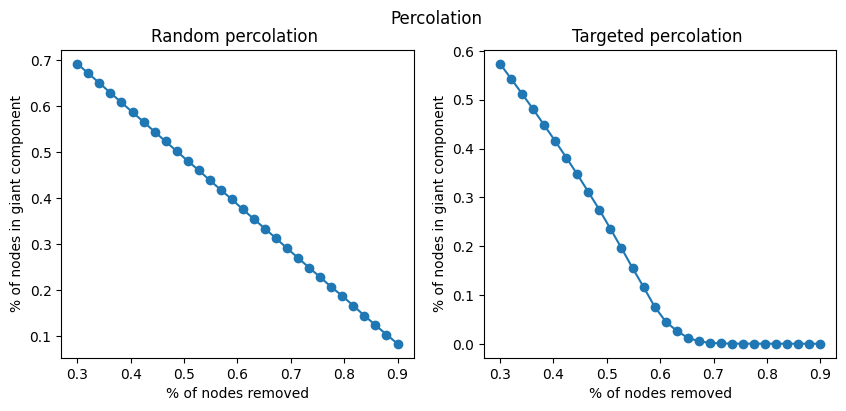

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].plot(fractions, random_percolation, marker = 'o')
axes[0].set_title(f'Random percolation ')
axes[0].set_xlabel(f'% of nodes removed')
axes[0].set_ylabel('% of nodes in giant component')


axes[1].plot(fractions, targeted_percolation, marker = 'o')
axes[1].set_title(f'Targeted percolation ')
axes[1].set_xlabel(f'% of nodes removed')
axes[1].set_ylabel('% of nodes in giant component')

plt.suptitle('Percolation')
plt.show()

In [ ]:
# comparison to artificial models
N = graph.number_of_nodes()
# scale free network
m = int(graph.number_of_edges() / graph.number_of_nodes())  # edges per new node
G_ba = nx.barabasi_albert_graph(N, m)

# small world network
k = int(graph_avg_degree)
p_rewire = 0.1
G_ws = nx.watts_strogatz_graph(N, k, p_rewire)

In [ ]:
df_compare = pd.DataFrame(columns=['Network', 'Density', 'Assortativity', 'Avg_degree','Num of components'])

for name, g in [('Real', graph), ('barabas-albert', G_ba), ('wats-strogats', G_ws)]:
    print(name)
    lcc = max(nx.connected_components(g), key=len)
    g_lcc = g.subgraph(lcc).copy()
    df_compare.loc[len(df_compare)] = [
        name,
        nx.density(g),
        nx.degree_assortativity_coefficient(g),
        np.mean(list(dict(nx.degree(g)).values())),
        nx.number_connected_components(g),
    ]

Real
barabas-albert
wats-strogats


In [ ]:
df_compare

,Network,Density,Assortativity,Avg_degree,Num of components
0,Real,0.000481,-0.086857,80.868423,1
1,barabas-albert,0.000476,-0.001225,79.980965,1
2,wats-strogats,0.000476,-0.001203,80.000000,1


In [ ]:
# find communities by maximizing modularity
from networkx.algorithms.community import louvain_communities

communities = louvain_communities(graph, seed=42)

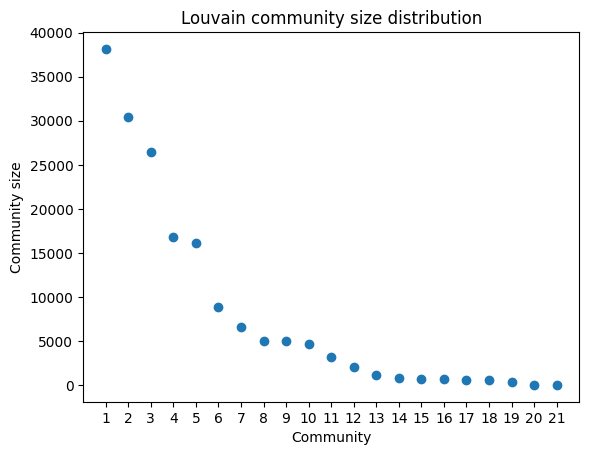

In [ ]:
# visualize community sizes
comm_sizes = sorted([len(c) for c in communities], reverse=True)

plt.figure()
plt.plot(range(1, len(comm_sizes)+1), comm_sizes, 'o')
plt.xticks(range(1, len(comm_sizes)+1))
plt.xlabel("Community")
plt.ylabel("Community size")
plt.title("Louvain community size distribution")
plt.show()


In [ ]:
# identify top languages in communities

top_languages = []
for i in range(len(communities)):
  vc = attributes.iloc[list(communities[i]),:]['language'].value_counts()
  top_language = vc.index[0]
  top_count = vc.iloc[0]
  top_languages.append(top_language)
  print(f'dominant language for community {i} = {top_language}')


dominant language for community 0 = EN
dominant language for community 1 = CS
dominant language for community 2 = EN
dominant language for community 3 = EN
dominant language for community 4 = EN
dominant language for community 5 = TH
dominant language for community 6 = EN
dominant language for community 7 = TR
dominant language for community 8 = ZH
dominant language for community 9 = FR
dominant language for community 10 = RU
dominant language for community 11 = EN
dominant language for community 12 = EN
dominant language for community 13 = ES
dominant language for community 14 = FI
dominant language for community 15 = PT
dominant language for community 16 = PL
dominant language for community 17 = IT
dominant language for community 18 = EN
dominant language for community 19 = HU
dominant language for community 20 = DE


In [ ]:
rows = []
for i, comm in enumerate(communities):
    langs = attributes.loc[list(comm), 'language'].value_counts()
    for lang, count in langs.items():
        rows.append({
            'community': i,
            'language': lang,
            'count': count
        })

df_cl = pd.DataFrame(rows)

In [ ]:
df_pivot = df_cl.pivot(
    index='community',
    columns='language',
    values='count'
).fillna(0)

In [ ]:
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)

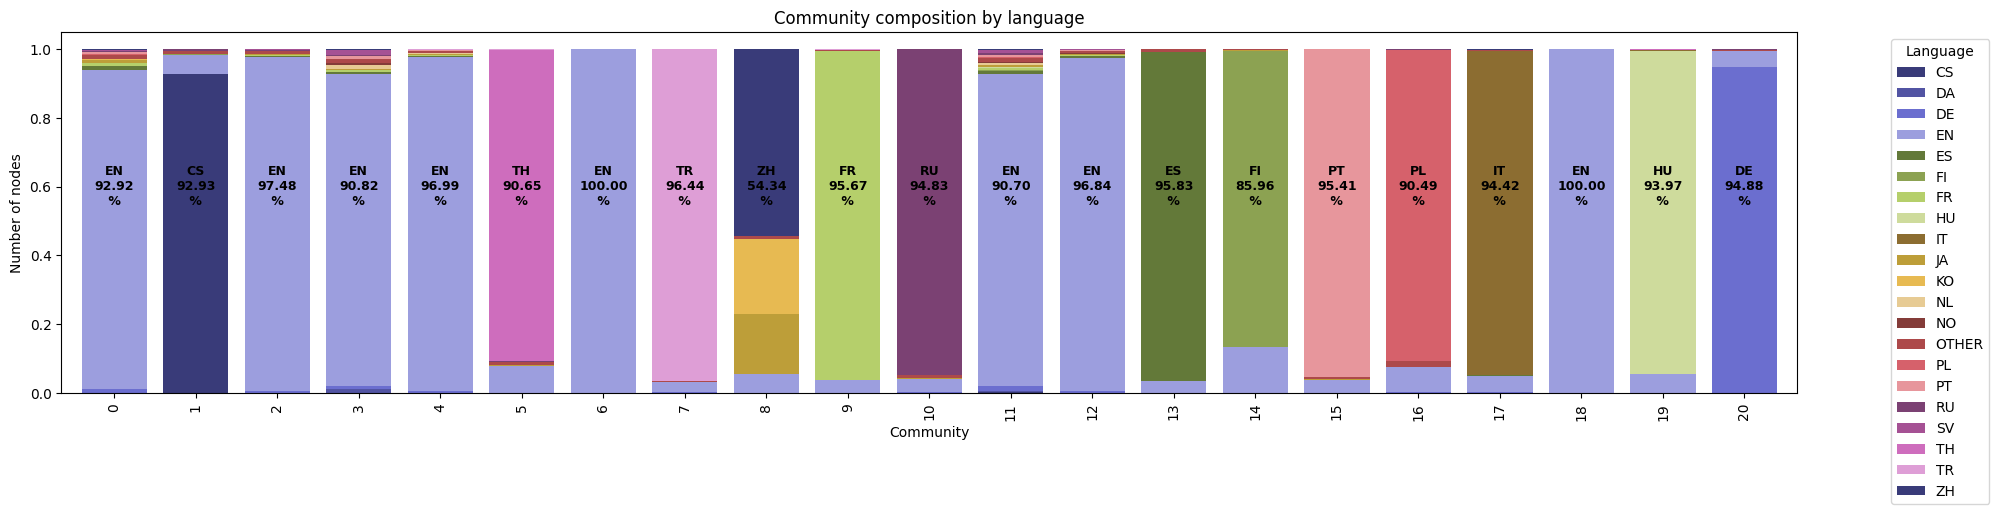

In [ ]:
fig, axes = plt.subplots(figsize=(20, 5))

colors = plt.cm.hsv(np.linspace(0, 1, 21))
colors = list(plt.cm.tab20b.colors)

df_pivot.plot(
    kind='bar',
    stacked=True,
    width=0.8,
    ax= axes,
    color = colors
)

for i in range(21):
    label = top_languages[i] + '\n' + f'{df_pivot.max(axis=1).loc[i]*100 :.2f}' + '\n % '
    y = 0.6

    axes.text(
        i, y,
        label,
        ha='center',
        va='center',
        fontsize=9,
        fontweight='bold',
        color='black'
    )

plt.xlabel('Community')
plt.ylabel('Number of nodes')
plt.title('Community composition by language')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(0,21))
plt.tight_layout()
plt.show()